In [351]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

# Загрузка данных

## Загрузка "грязных" данных

In [352]:
with open('output.json', 'r') as file:
    data = json.load(file)


def extract_data(data):
    rows = []
    for url, content in data.items():
        track_info = content.get('track', {})
        for race_type, results in content.get('drivers', {}).items():
            for result in results:
                row = {
                    'URL': url,
                    'Track Name': track_info.get('Track Name'),
                    'Country': track_info.get('Country'),
                    'City': track_info.get('City'),
                    'Date': track_info.get('Date'),
                    'Length (Km)': track_info.get('Length (Km)'),
                    'Race Type': race_type,
                    'Position': result.get('Position'),
                    'Car Number': result.get('Car Number'),
                    'Driver Name': result.get('Driver Name'),
                    'Team Name': result.get('Team Name'),
                    'Laps': result.get('Laps'),
                    'Time': result.get('Time'),
                    'Gap': result.get('Gap'),
                    'Interval': result.get('Interval'),
                    'KPH': result.get('KPH'),
                    'Best Lap Time': result.get('Best Lap Time')
                }
                rows.append(row)
    return pd.DataFrame(rows)


df = extract_data(data)
df

,URL,Track Name,Country,City,Date,Length (Km),Race Type,Position,Car Number,Driver Name,Team Name,Laps,Time,Gap,Interval,KPH,Best Lap Time
0,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,14-16 April 2017,5.412,Sprint Race Results,1,1,C. Leclerc,PREMA Racing,23,43:01.023,0,0,173.275,1:44.074
1,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,14-16 April 2017,5.412,Sprint Race Results,2,5,L. Ghiotto,RUSSIAN TIME,23,43:02.592,1.569,0,173.17,1:47.043
2,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,14-16 April 2017,5.412,Sprint Race Results,3,9,O. Rowland,DAMS,23,43:03.921,2.898,1.329,173.081,1:47.175
3,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,14-16 April 2017,5.412,Sprint Race Results,4,10,N. Latifi,DAMS,23,43:08.598,7.575,4.677,172.768,1:47.760
4,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,14-16 April 2017,5.412,Sprint Race Results,5,15,J. King,MP Motorsport,23,43:10.985,9.962,2.387,172.609,1:46.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,06-08 December 2024,5.281,Free Practice Results,18,15,A. Cordeel,Invicta Virtuosi Racing,15,1:38.674,1.285,0.012,192.67,11:48:44
7184,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,06-08 December 2024,5.281,Free Practice Results,19,2,F. Colapinto,MP Motorsport,16,1:39.044,1.655,0.370,191.951,11:49:53
7185,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,06-08 December 2024,5.281,Free Practice Results,20,21,P. Aron,Trident,19,1:39.189,1.800,0.145,191.67,11:49:05
7186,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,06-08 December 2024,5.281,Free Practice Results,21,17,J. Mason,PHM Racing by Charouz,18,1:40.853,3.464,1.664,188.508,11:50:05


## Предобработка данных

In [353]:
df['Position'] = pd.to_numeric(df['Position'], errors = 'coerce')
df['Car Number'] = pd.to_numeric(df['Car Number'], errors = 'coerce')
df['Laps'] = pd.to_numeric(df['Laps'], errors = 'coerce')
df['KPH'] = pd.to_numeric(df['KPH'], errors = 'coerce')
df['Length (Km)'] = pd.to_numeric(df['Length (Km)'], errors = 'coerce')
df['Date'] = pd.to_datetime(df['Date'])

df = df.replace({np.nan: None})

df

/var/folders/nw/6zqss69d42g8tk6wqjfhvfz80000gn/T/ipykernel_95439/1979384612.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,URL,Track Name,Country,City,Date,Length (Km),Race Type,Position,Car Number,Driver Name,Team Name,Laps,Time,Gap,Interval,KPH,Best Lap Time
0,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,1.0,1,C. Leclerc,PREMA Racing,23.0,43:01.023,0,0,173.275,1:44.074
1,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,2.0,5,L. Ghiotto,RUSSIAN TIME,23.0,43:02.592,1.569,0,173.17,1:47.043
2,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,3.0,9,O. Rowland,DAMS,23.0,43:03.921,2.898,1.329,173.081,1:47.175
3,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,4.0,10,N. Latifi,DAMS,23.0,43:08.598,7.575,4.677,172.768,1:47.760
4,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,5.0,15,J. King,MP Motorsport,23.0,43:10.985,9.962,2.387,172.609,1:46.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7183,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,2006-12-08 20:24:00,5.281,Free Practice Results,18.0,15,A. Cordeel,Invicta Virtuosi Racing,15.0,1:38.674,1.285,0.012,192.67,11:48:44
7184,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,2006-12-08 20:24:00,5.281,Free Practice Results,19.0,2,F. Colapinto,MP Motorsport,16.0,1:39.044,1.655,0.370,191.951,11:49:53
7185,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,2006-12-08 20:24:00,5.281,Free Practice Results,20.0,21,P. Aron,Trident,19.0,1:39.189,1.800,0.145,191.67,11:49:05
7186,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,2006-12-08 20:24:00,5.281,Free Practice Results,21.0,17,J. Mason,PHM Racing by Charouz,18.0,1:40.853,3.464,1.664,188.508,11:50:05


## Удалим гонщиков у которых DNF

In [354]:
df = df.dropna(subset = ['Position', 'Laps', 'KPH', 'Length (Km)'])

In [355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7138 entries, 0 to 7187
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   URL            7138 non-null   object        
 1   Track Name     7138 non-null   object        
 2   Country        7138 non-null   object        
 3   City           7138 non-null   object        
 4   Date           7138 non-null   datetime64[ns]
 5   Length (Km)    7138 non-null   float64       
 6   Race Type      7138 non-null   object        
 7   Position       7138 non-null   object        
 8   Car Number     7138 non-null   int64         
 9   Driver Name    7138 non-null   object        
 10  Team Name      7138 non-null   object        
 11  Laps           7138 non-null   object        
 12  Time           7138 non-null   object        
 13  Gap            7138 non-null   object        
 14  Interval       7138 non-null   object        
 15  KPH            7138 non-nu

## Создание нового файла с данными

In [356]:
df.to_csv('Formula2_Race_Results.csv', index = False)

# Визуализация данных

## Распределение количества кругов (Laps) по позициям (Position)

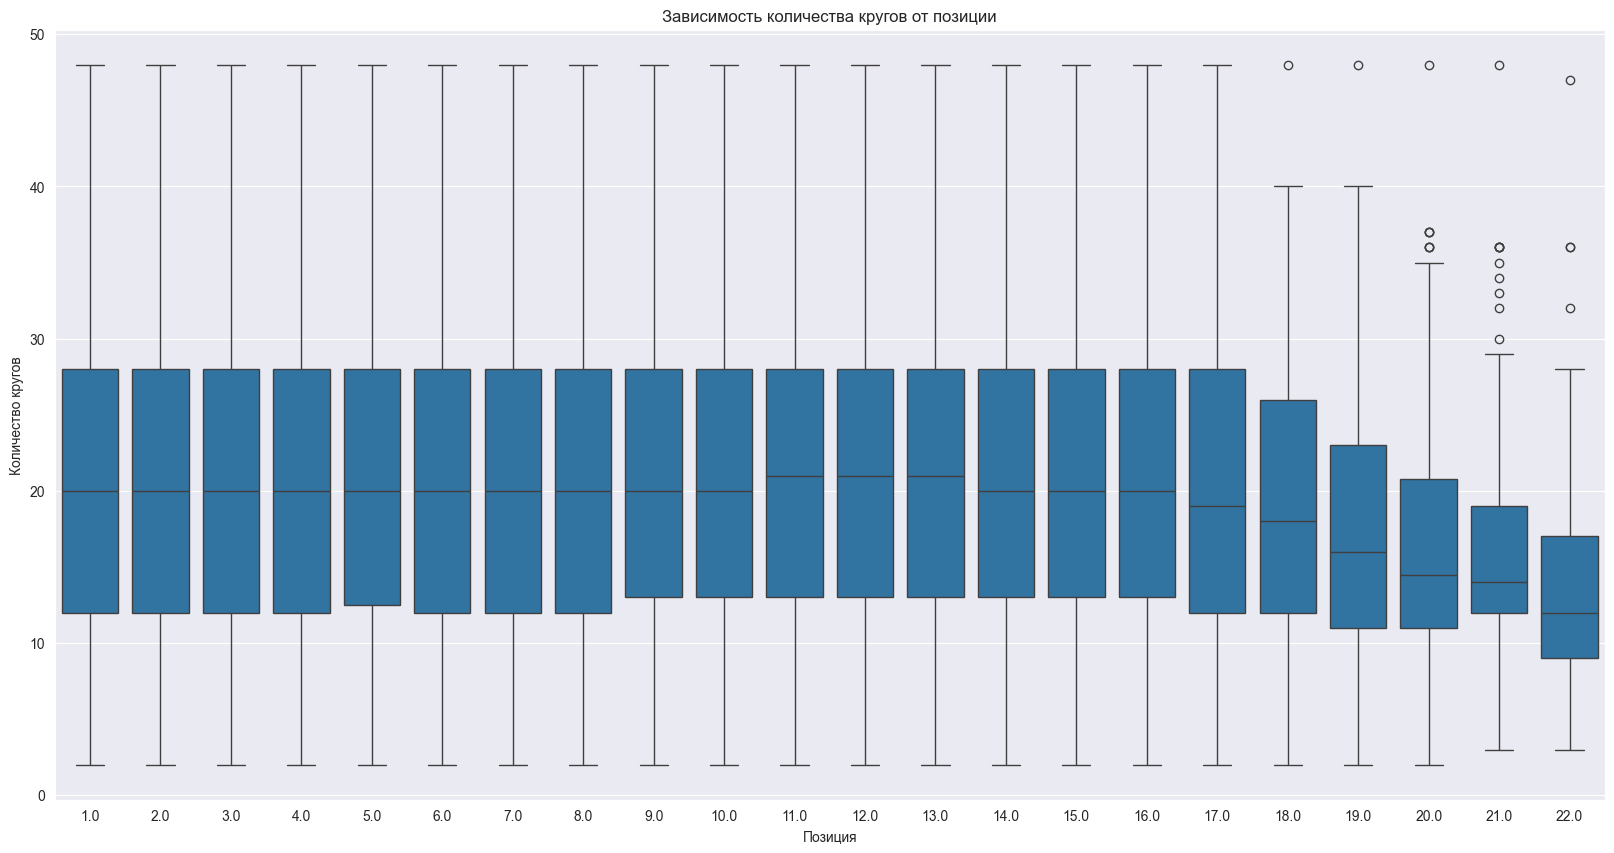

In [357]:
plt.figure(figsize = (20, 10))
sns.boxplot(x = 'Position', y = 'Laps', data = df)
plt.title('Зависимость количества кругов от позиции')
plt.xlabel('Позиция')
plt.ylabel('Количество кругов')
plt.show()

## Средняя скорость (KPH) по различным трассам (Track Name)

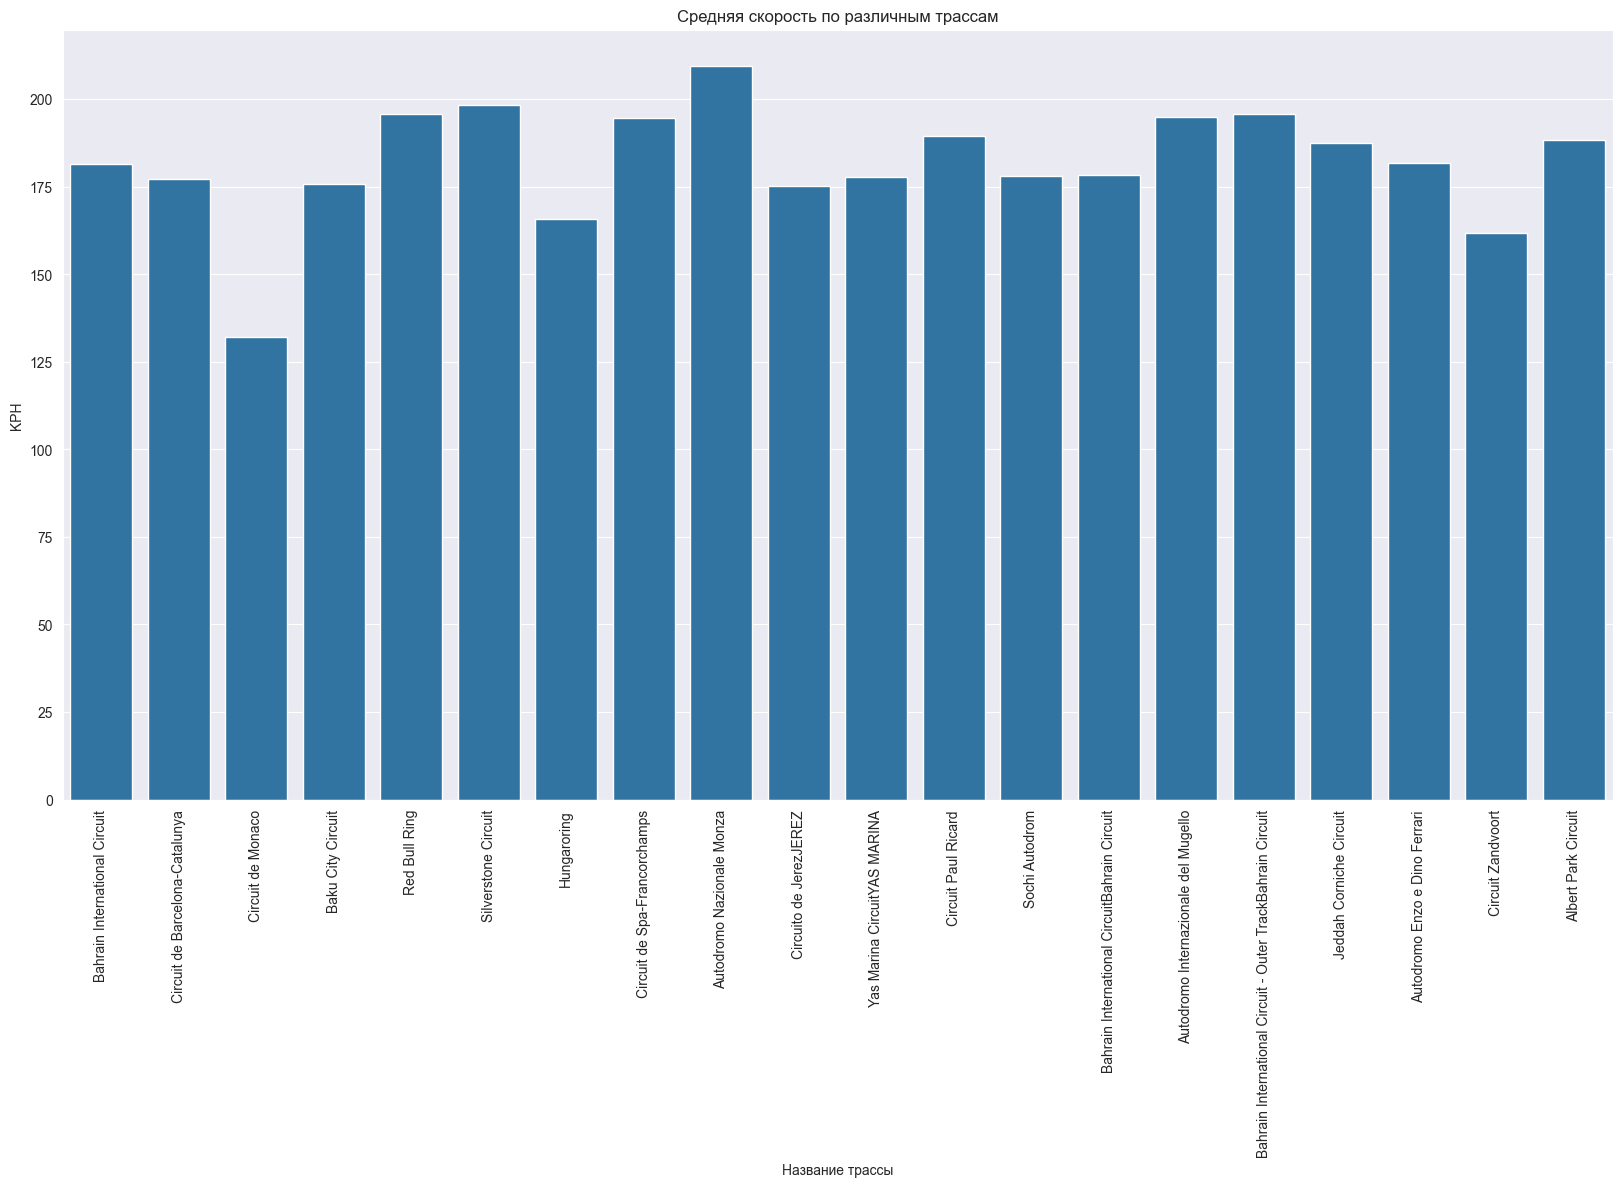

In [358]:
plt.figure(figsize = (20, 10))
sns.barplot(x = 'Track Name', y = 'KPH', data = df, errorbar = None)
plt.xticks(rotation = 90)
plt.title('Средняя скорость по различным трассам')
plt.xlabel('Название трассы')
plt.ylabel('KPH')
plt.show()

## Количество кругов (Laps) по командам (Team Name)

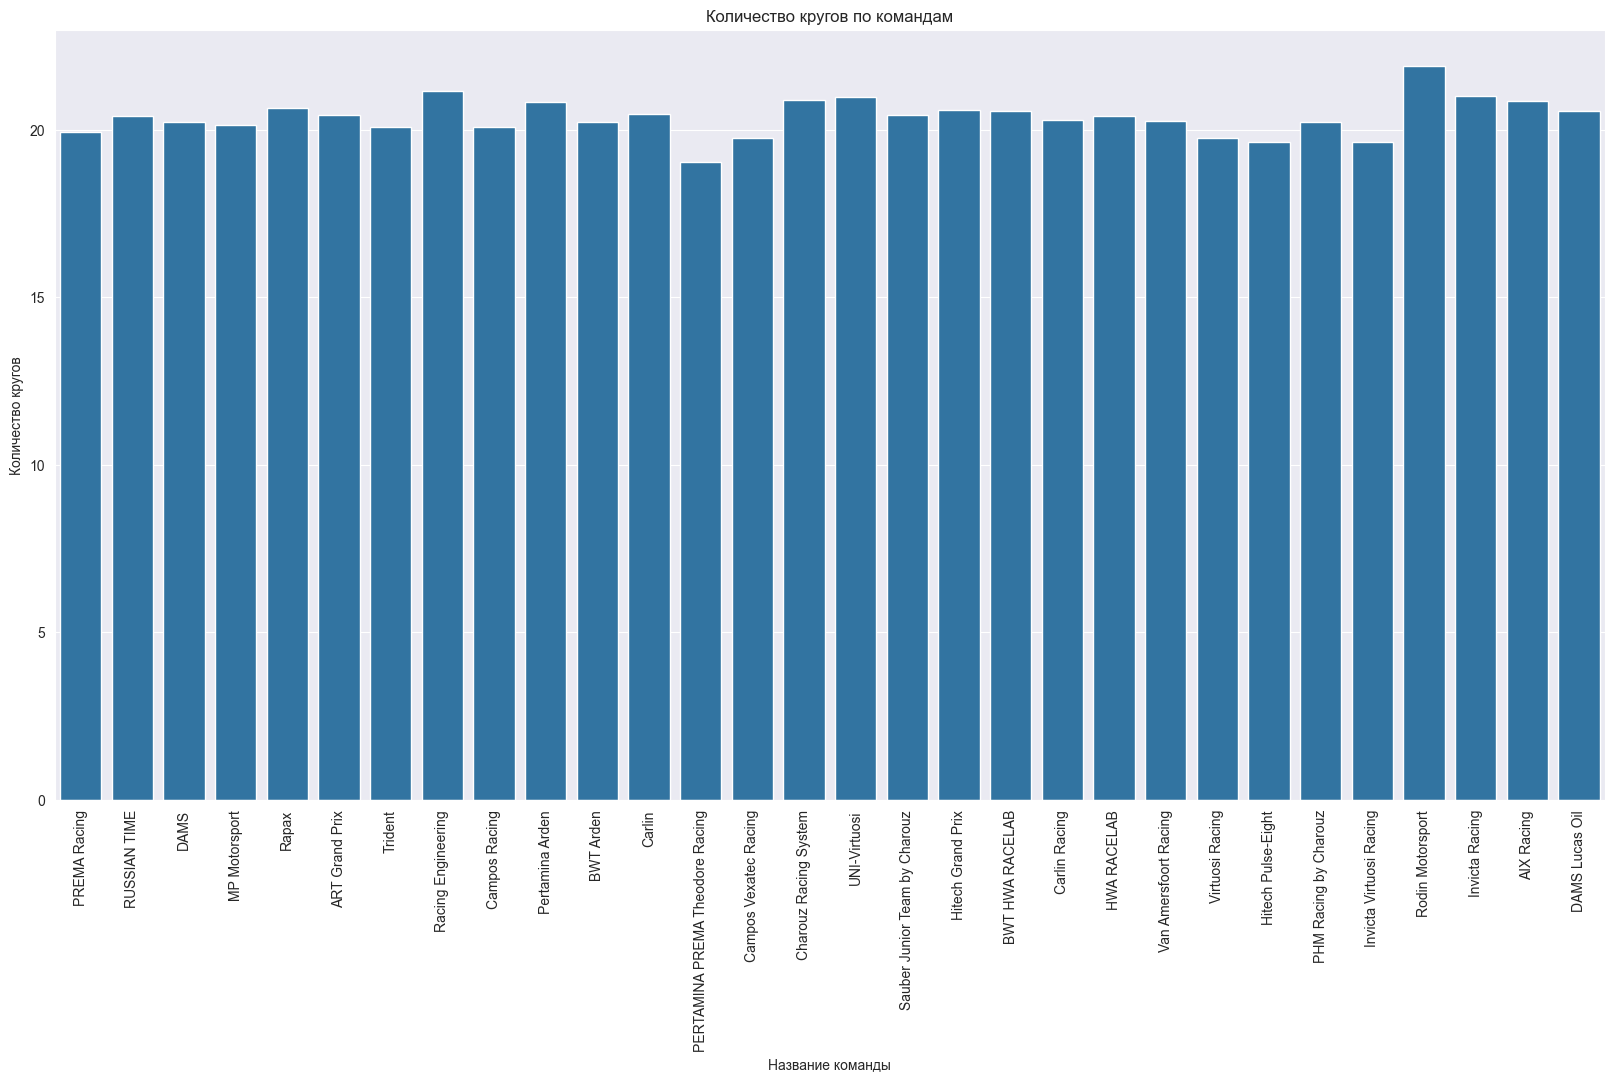

In [359]:
plt.figure(figsize = (20, 10))
sns.barplot(x = 'Team Name', y = 'Laps', data = df, errorbar = None)
plt.xticks(rotation = 90)
plt.title('Количество кругов по командам')
plt.xlabel('Название команды')
plt.ylabel('Количество кругов')
plt.show()

## Лучшее время круга (Best Lap Time) по различным трассам (Track Name) за последние 2 года

In [360]:
def convert_lap_time(time_str):
    if pd.isna(time_str):
        return None
    try:
        minutes, seconds = time_str.split(':')
        return int(minutes) * 60 + float(seconds)
    except:
        return None

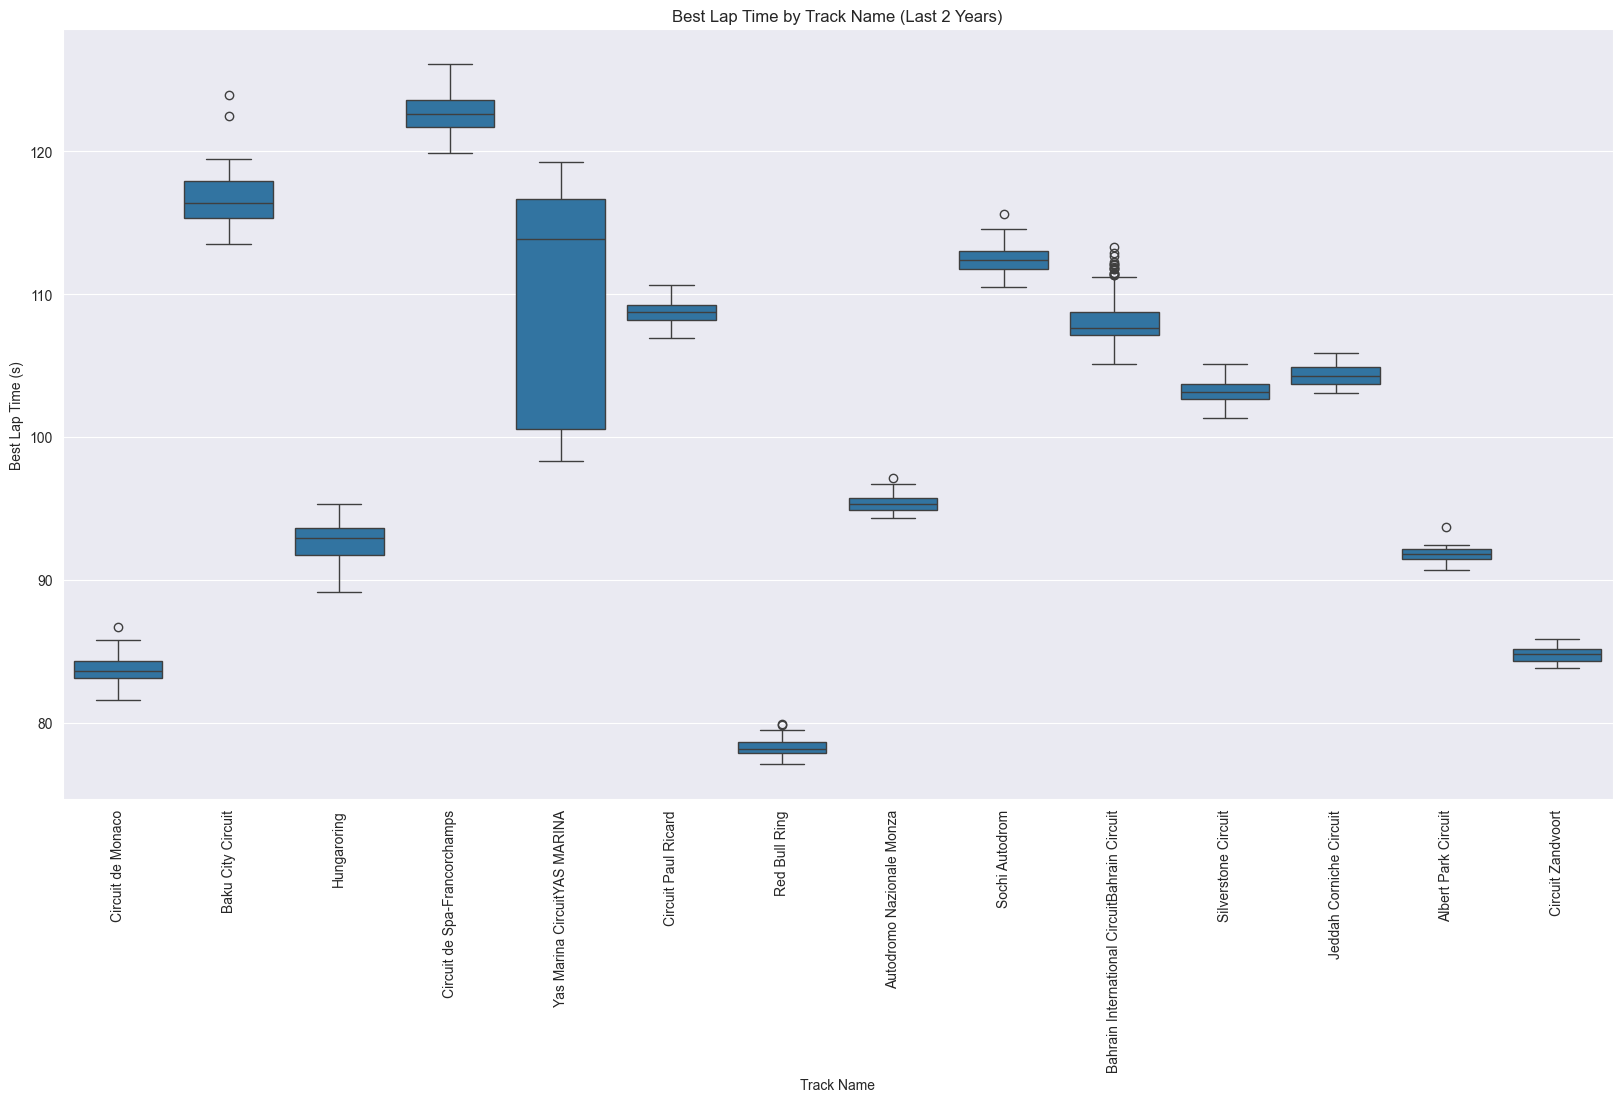

In [361]:
two_years_ago = pd.Timestamp.now() - pd.DateOffset(years = 2)
recent_data = df[df['Date'] >= two_years_ago].copy()

recent_data['Best Lap Time (s)'] = recent_data['Best Lap Time'].apply(convert_lap_time)

plt.figure(figsize = (20, 10))
sns.boxplot(x = 'Track Name', y = 'Best Lap Time (s)', data = recent_data)
plt.xticks(rotation = 90)
plt.title('Best Lap Time by Track Name (Last 2 Years)')
plt.xlabel('Track Name')
plt.ylabel('Best Lap Time (s)')
plt.show()

## Средняя скорость (KPH) по различным городам (City)


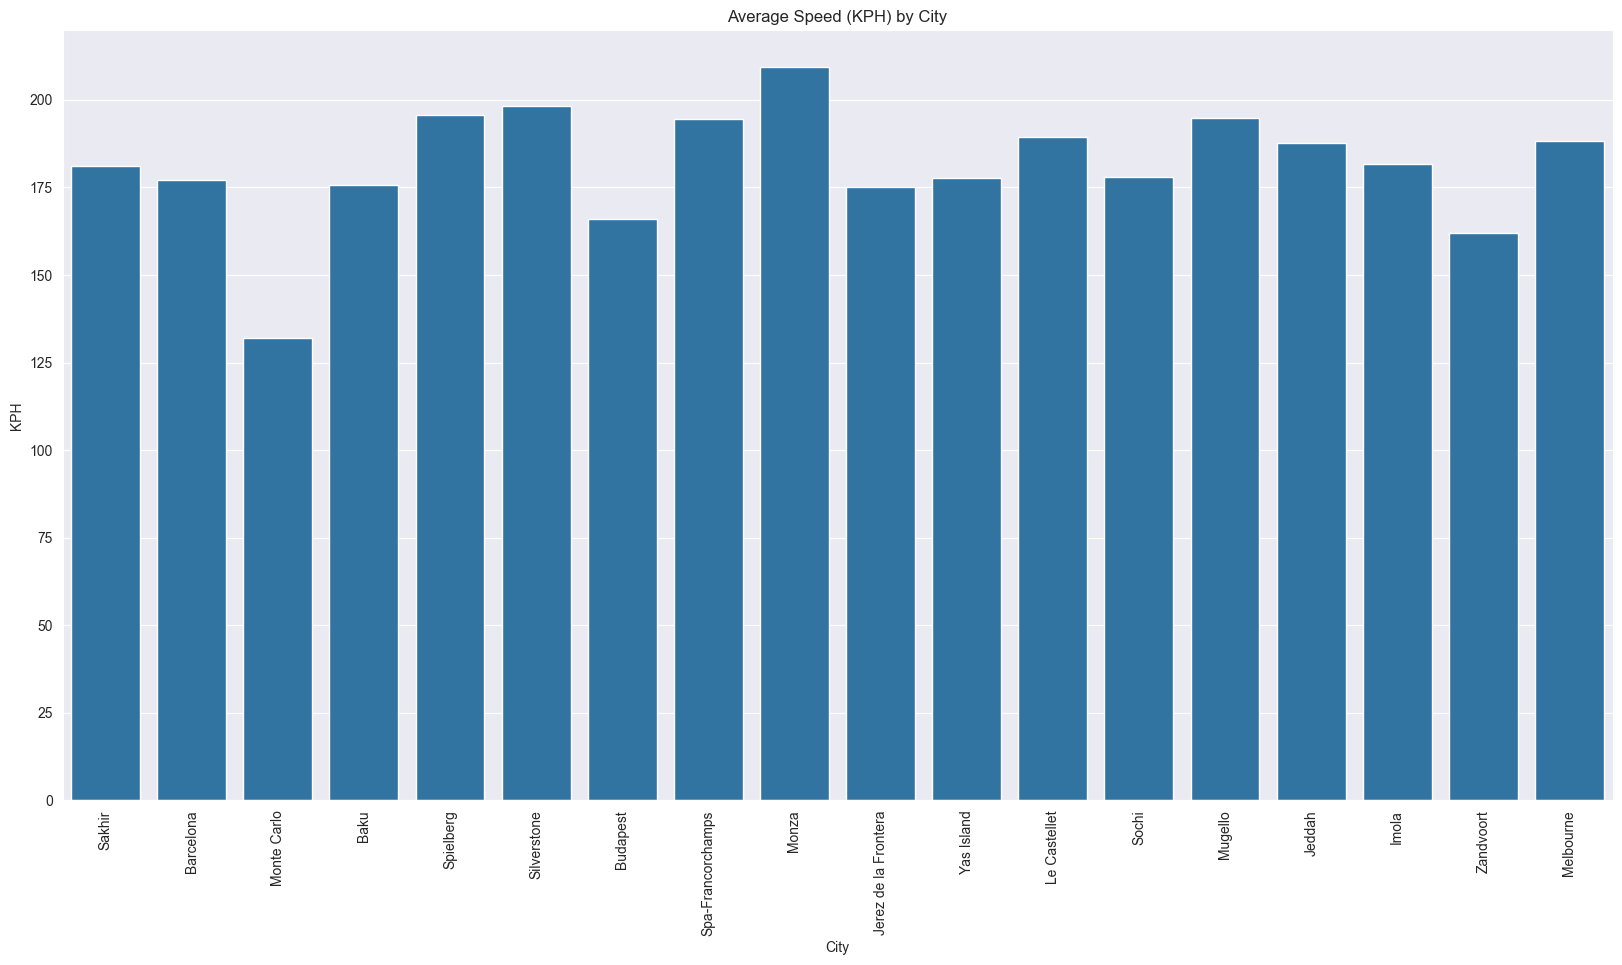

In [362]:
plt.figure(figsize = (20, 10))
sns.barplot(x = 'City', y = 'KPH', data = df, errorbar = None)
plt.xticks(rotation = 90)
plt.title('Average Speed (KPH) by City')
plt.xlabel('City')
plt.ylabel('KPH')
plt.show()

# Новые признаки

Исходя из наших данных мы можем создать новые признаки, которые могут быть полезными для дальнейшего анализа:
1. Средняя скорость заезда всех гонщиков
2. Среднее время кругавсех гонщиков

In [363]:
average_speed = df.groupby(['URL', 'Race Type'])['KPH'].mean().reset_index()
average_speed.columns = ['URL', 'Race Type', 'Average Speed (KPH)']

df = df.merge(average_speed, on = ['URL', 'Race Type'])
df

,URL,Track Name,Country,City,Date,Length (Km),Race Type,Position,Car Number,Driver Name,Team Name,Laps,Time,Gap,Interval,KPH,Best Lap Time,Average Speed (KPH)
0,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,1.0,1,C. Leclerc,PREMA Racing,23.0,43:01.023,0,0,173.275,1:44.074,171.699889
1,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,2.0,5,L. Ghiotto,RUSSIAN TIME,23.0,43:02.592,1.569,0,173.17,1:47.043,171.699889
2,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,3.0,9,O. Rowland,DAMS,23.0,43:03.921,2.898,1.329,173.081,1:47.175,171.699889
3,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,4.0,10,N. Latifi,DAMS,23.0,43:08.598,7.575,4.677,172.768,1:47.760,171.699889
4,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,5.0,15,J. King,MP Motorsport,23.0,43:10.985,9.962,2.387,172.609,1:46.998,171.699889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7133,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,2006-12-08 20:24:00,5.281,Free Practice Results,18.0,15,A. Cordeel,Invicta Virtuosi Racing,15.0,1:38.674,1.285,0.012,192.67,11:48:44,192.462864
7134,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,2006-12-08 20:24:00,5.281,Free Practice Results,19.0,2,F. Colapinto,MP Motorsport,16.0,1:39.044,1.655,0.370,191.951,11:49:53,192.462864
7135,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,2006-12-08 20:24:00,5.281,Free Practice Results,20.0,21,P. Aron,Trident,19.0,1:39.189,1.800,0.145,191.67,11:49:05,192.462864
7136,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,2006-12-08 20:24:00,5.281,Free Practice Results,21.0,17,J. Mason,PHM Racing by Charouz,18.0,1:40.853,3.464,1.664,188.508,11:50:05,192.462864


In [364]:
df['Best Lap Time (s)'] = df['Best Lap Time'].apply(convert_lap_time)
average_lap_time = df.groupby(['URL', 'Race Type'])['Best Lap Time (s)'].mean().reset_index()
average_lap_time.columns = ['URL', 'Race Type', 'Average Lap Time (s)']

df = df.merge(average_lap_time, on = ['URL', 'Race Type'])
df

,URL,Track Name,Country,City,Date,Length (Km),Race Type,Position,Car Number,Driver Name,Team Name,Laps,Time,Gap,Interval,KPH,Best Lap Time,Average Speed (KPH),Best Lap Time (s),Average Lap Time (s)
0,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,1.0,1,C. Leclerc,PREMA Racing,23.0,43:01.023,0,0,173.275,1:44.074,171.699889,104.074,107.052556
1,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,2.0,5,L. Ghiotto,RUSSIAN TIME,23.0,43:02.592,1.569,0,173.17,1:47.043,171.699889,107.043,107.052556
2,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,3.0,9,O. Rowland,DAMS,23.0,43:03.921,2.898,1.329,173.081,1:47.175,171.699889,107.175,107.052556
3,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,4.0,10,N. Latifi,DAMS,23.0,43:08.598,7.575,4.677,172.768,1:47.760,171.699889,107.760,107.052556
4,https://www.fiaformula2.com/Results?raceid=972,Bahrain International Circuit,Bahrain,Sakhir,2014-04-16 20:17:00,5.412,Sprint Race Results,5.0,15,J. King,MP Motorsport,23.0,43:10.985,9.962,2.387,172.609,1:46.998,171.699889,106.998,107.052556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7133,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,2006-12-08 20:24:00,5.281,Free Practice Results,18.0,15,A. Cordeel,Invicta Virtuosi Racing,15.0,1:38.674,1.285,0.012,192.67,11:48:44,192.462864,NaN,NaN
7134,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,2006-12-08 20:24:00,5.281,Free Practice Results,19.0,2,F. Colapinto,MP Motorsport,16.0,1:39.044,1.655,0.370,191.951,11:49:53,192.462864,NaN,NaN
7135,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,2006-12-08 20:24:00,5.281,Free Practice Results,20.0,21,P. Aron,Trident,19.0,1:39.189,1.800,0.145,191.67,11:49:05,192.462864,NaN,NaN
7136,https://www.fiaformula2.com/Results?raceid=1077,Yas Marina CircuitYAS MARINA,United Arab Emirates,Yas Island,2006-12-08 20:24:00,5.281,Free Practice Results,21.0,17,J. Mason,PHM Racing by Charouz,18.0,1:40.853,3.464,1.664,188.508,11:50:05,192.462864,NaN,NaN


# Гипотезы

## Гипотеза 1
### Консистентность результатов в разных форматах гонок
Гонщики, которые показывают хорошие результаты в квалификационных заездах, с большей вероятностью занимают топовые позиции как в спринтерских, так и в основных гонках

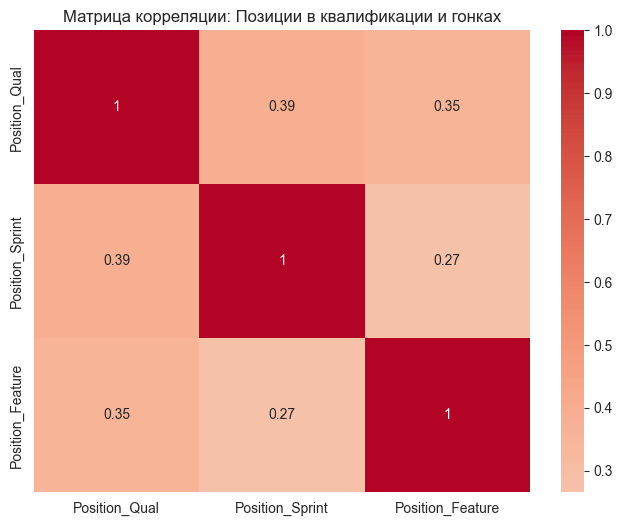

In [365]:
qualifying_results = df[df['Race Type'] == 'Qualifying Session Results']
sprint_race_results = df[df['Race Type'] == 'Sprint Race Results']
feature_race_results = df[df['Race Type'] == 'Feature Race Results']

merged_sprint = pd.merge(qualifying_results[['Driver Name', 'Position']],
                         sprint_race_results[['Driver Name', 'Position']], on = 'Driver Name',
                         suffixes = ('_Qual', '_Sprint'))
merged_feature = pd.merge(qualifying_results[['Driver Name', 'Position']],
                          feature_race_results[['Driver Name', 'Position']], on = 'Driver Name',
                          suffixes = ('_Qual', '_Feature'))

merged_sprint = merged_sprint.rename(
    columns = {'Position_Qual': 'Position_Qual', 'Position_Sprint': 'Position_Sprint'})
merged_feature = merged_feature.rename(
    columns = {'Position_Qual': 'Position_Qual', 'Position_Feature': 'Position_Feature'})

correlation_data = pd.merge(merged_sprint, merged_feature, on = ['Driver Name', 'Position_Qual'])

correlation_matrix = correlation_data[
    ['Position_Qual', 'Position_Sprint', 'Position_Feature']].corr()

plt.figure(figsize = (8, 6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', center = 0)
plt.title('Матрица корреляции: Позиции в квалификации и гонках')
plt.show()

## Вывод
Мы видим, что позиция в квалификации не сильно коррелирует с позицией в спринтерской гонке, но слабо коррелирует с позицией в основной гонке

## Гипотеза 2
### Влияние длины трассы на время гонки
Длина трассы значительно влияет на общее время гонки и средние скорости гонщиков

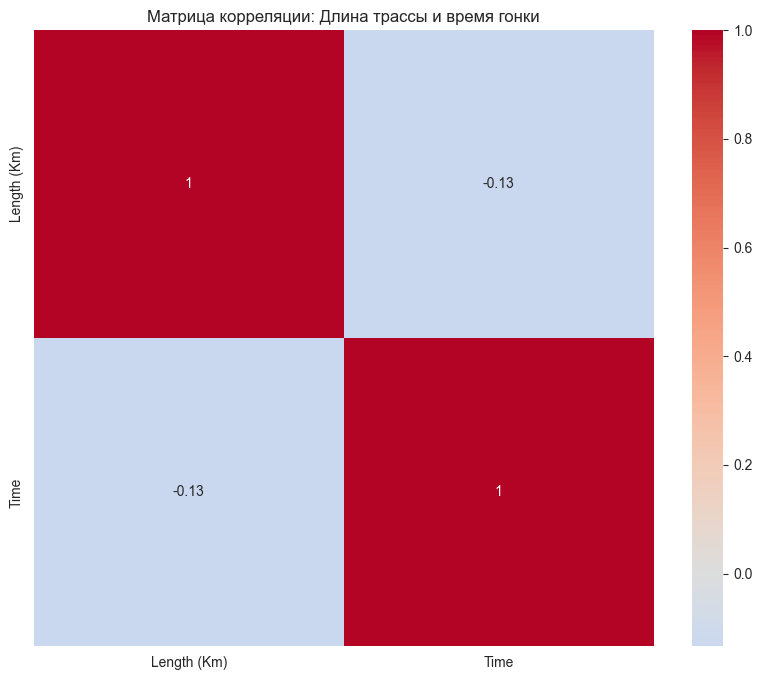

In [366]:
df_race = df[df['Race Type'].str.contains('Race Results')]

df_race.loc[:, 'Time'] = pd.to_timedelta(df_race['Time'], errors = 'coerce').dt.total_seconds()

correlation_matrix_2 = df_race[['Length (Km)', 'Time']].dropna().corr()

plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix_2, annot = True, cmap = 'coolwarm', center = 0)
plt.title('Матрица корреляции: Длина трассы и время гонки')
plt.show()

## Вывод
Мы видим, что длина трассы очень слабо коррелирует с временем гонки, что отвергает нашу гипотезу

## Гипотеза 3
### Влияние команды на результаты гонки
Некоторые команды стабильно показывают лучшие результаты по сравнению с другими, независимо от трассы или типа гонки

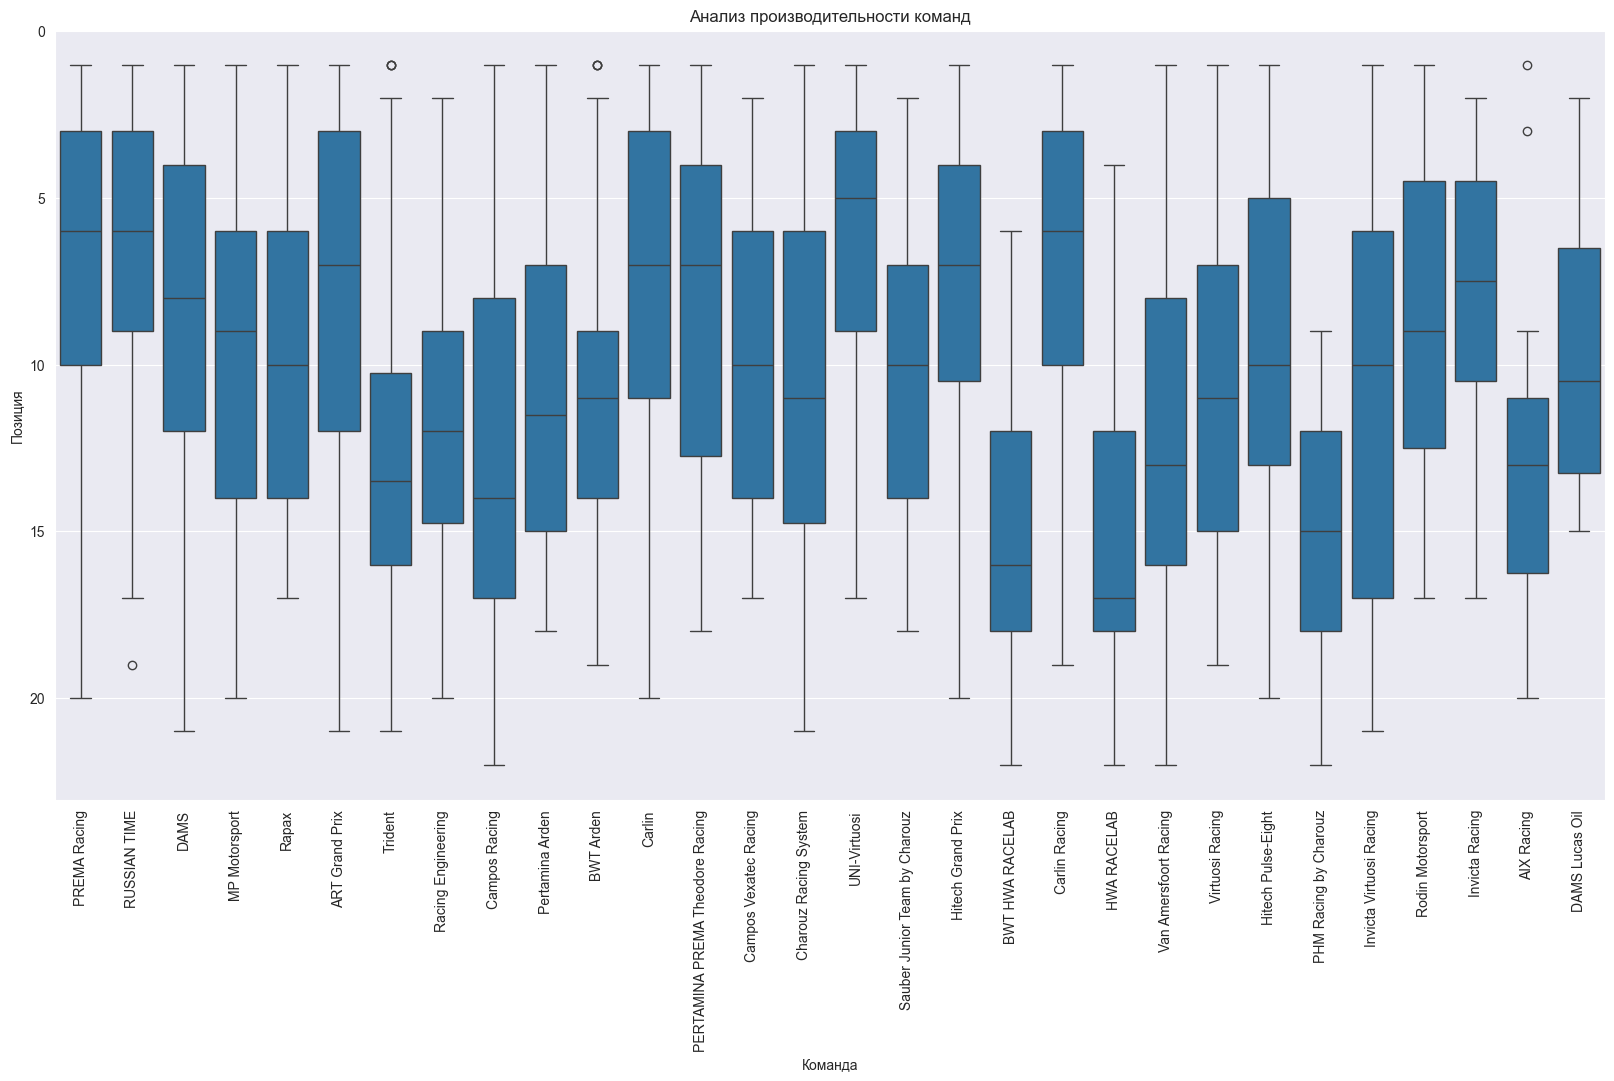

In [367]:
df_race = df[df['Race Type'].str.contains('Race Results')]

plt.figure(figsize = (20, 10))
sns.boxplot(data = df_race, x = 'Team Name', y = 'Position')
plt.xticks(rotation = 90)
plt.title('Анализ производительности команд')
plt.xlabel('Команда')
plt.ylabel('Позиция')
plt.gca().invert_yaxis()
plt.show()

## Вывод
Мы видим, что некоторые команды стабильно показывают лучшие результаты по сравнению с другими, что подтверждает нашу гипотезу

## Гипотеза 4
### Индивидуальное мастерство гонщика влияет на результаты гонки
Некоторые гонщики стабильно превосходят своих напарников по команде, что говорит о значительной роли индивидуального мастерства в результатах гонок

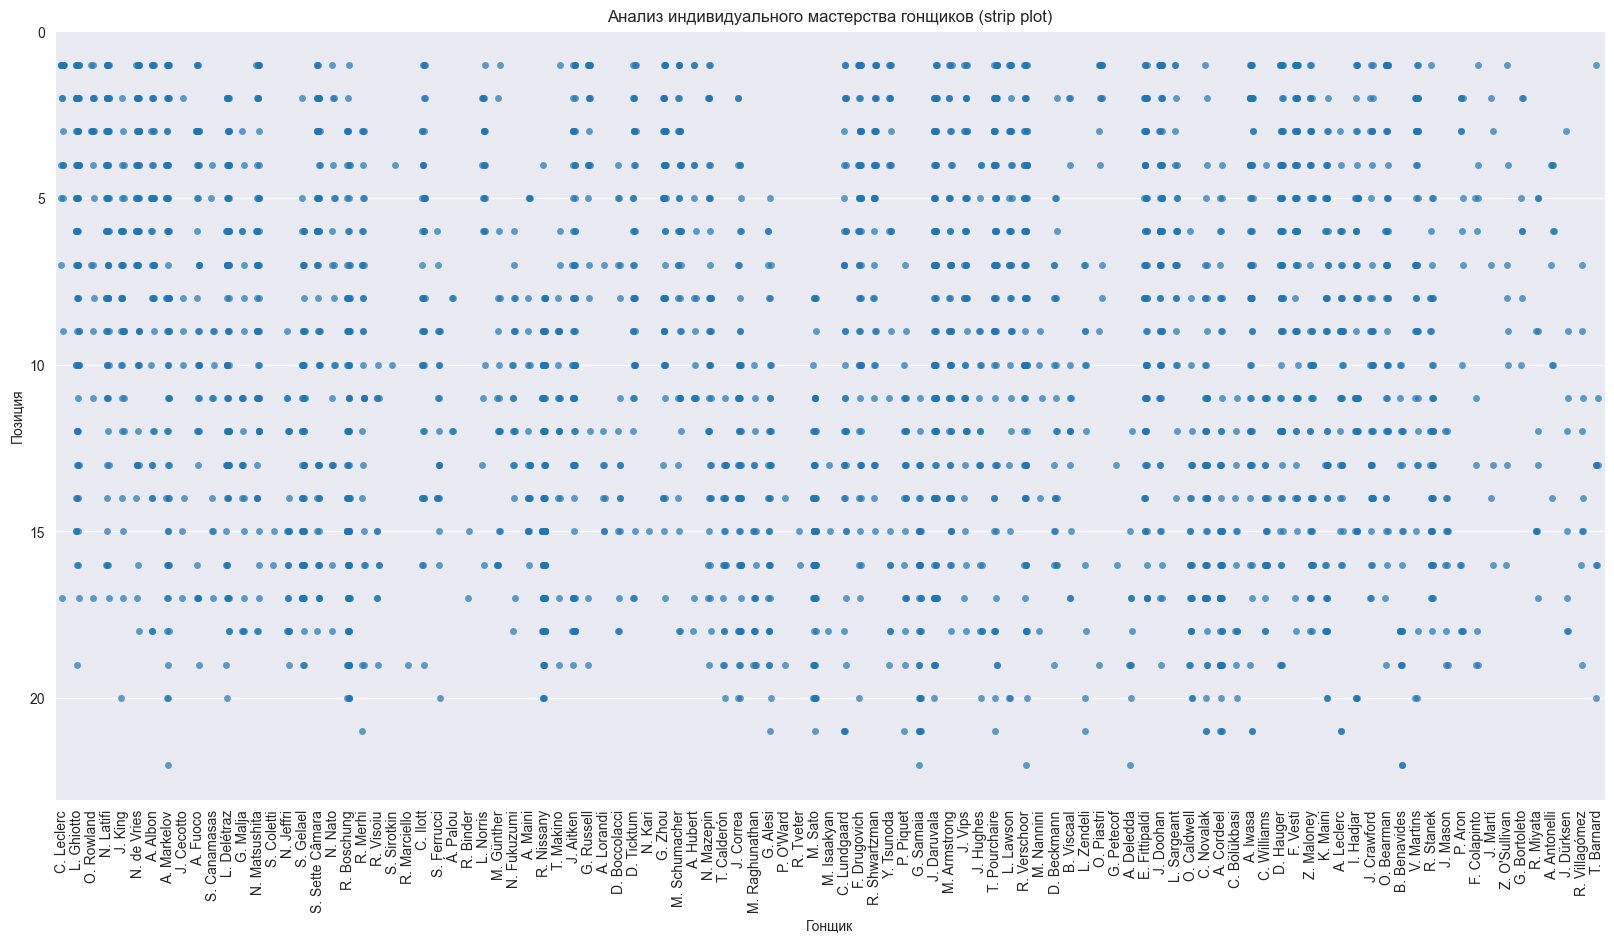

In [368]:
plt.figure(figsize = (20, 10))
sns.stripplot(data = df_race, x = 'Driver Name', y = 'Position', jitter = True, alpha = 0.7)
plt.xticks(rotation = 90)
plt.title('Анализ индивидуального мастерства гонщиков (strip plot)')
plt.xlabel('Гонщик')
plt.ylabel('Позиция')
plt.gca().invert_yaxis()
plt.show()

## Вывод
Мы видим, что некоторые гонщики стабильно превосходят своих напарников по команде, что подтверждает нашу гипотезу

## Гипотеза 5
### Корреляция лучшего времени круга с итоговой позицией в гонке очень высока
Лучшее время круга, показанное гонщиком во время гонки, сильно коррелирует с его итоговой позицией в этой гонке

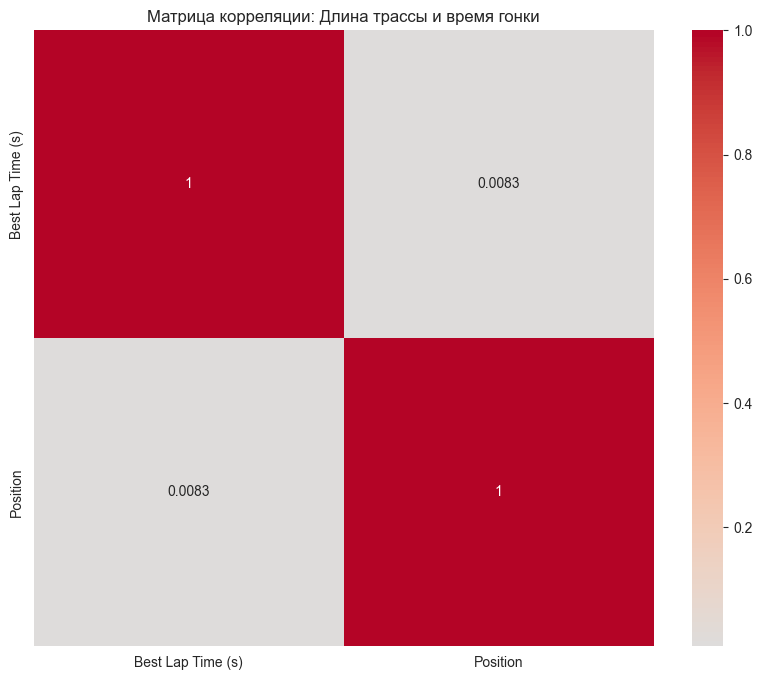

In [369]:
correlation_matrix_5 = df_race[['Best Lap Time (s)', 'Position']].dropna().corr()

plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix_5, annot = True, cmap = 'coolwarm', center = 0)
plt.title('Матрица корреляции: Длина трассы и время гонки')
plt.show()

## Вывод
Мы видим, что лучшее время круга очень слабо коррелирует с итоговой позицией в гонке, что отвергает нашу гипотезу

# Машинное обучение

Исходя из наших данных самым разумным будет предсказывать позицию гонщика в гонке

In [370]:
df.dropna(subset = ['Position'], inplace = True)

In [371]:
features = ['Laps', 'Best Lap Time (s)', 'Length (Km)']
X = df[features]
y = df['Position']

In [372]:
imputer = SimpleImputer(strategy = 'mean')
X = imputer.fit_transform(X)

random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = random_state)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state = random_state),
    "Gradient Boosting": GradientBoostingRegressor(random_state = random_state),
    "XGBoost": XGBRegressor(random_state = random_state)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    results[model_name] = mae
    print(f'{model_name} Mean Absolute Error: {mae}')

results_df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['Mean Absolute Error'])

Linear Regression Mean Absolute Error: 4.917548968635544
Decision Tree Mean Absolute Error: 4.934724784846493
Gradient Boosting Mean Absolute Error: 4.774113032125431
XGBoost Mean Absolute Error: 4.711135259529455


## Вывод
Самой точной моделью оказалась модель XGBoost, которая показала наименьшую среднюю абсолютную ошибку, но она всё ещё большая. Попробуем улучшить её

## Подбор гиперпараметров

In [373]:
param_dist = {
    'n_estimators': range(50, 1000, 50),
    'learning_rate': np.linspace(0.01, 0.2, 20),
    'max_depth': range(3, 15, 2),
    'subsample': np.linspace(0.7, 1.0, 10),
    'colsample_bytree': np.linspace(0.7, 1.0, 10),
    'gamma': np.linspace(0, 0.5, 10)
}

xgb_model = XGBRegressor(random_state = random_state)
random_search = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_dist,
                                   n_iter = 200, cv = 3, scoring = 'neg_mean_absolute_error',
                                   n_jobs = -1, verbose = 0, random_state = random_state,
                                   error_score = 'raise')

try:
    random_search.fit(X_train, y_train)
except ValueError as e:
    print(f"Произошла ошибка: {e}")

if random_search.best_estimator_ is not None:
    best_xgb_model = random_search.best_estimator_

    y_pred = best_xgb_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    print(f'Best XGBoost Model Mean Absolute Error: {mae}')
    print(f'Best Parameters:')
    for param, value in random_search.best_params_.items():
        print(f'{param}: {value}')

    best_results_df = pd.DataFrame([{'Model': 'XGBoost', 'Mean Absolute Error': mae,
                                     'Best Parameters': random_search.best_params_}])
else:
    print("RandomizedSearchCV не нашел ни одной подходящей комбинации гиперпараметров.")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGBoost Model Mean Absolute Error: 4.733998919234557
Best Parameters:
subsample: 1.0
n_estimators: 250
max_depth: 7
learning_rate: 0.08
gamma: 0.2777777777777778
colsample_bytree: 0.7


## Вывод
Мы смогли улучшить нашу модель, но очень незначительно, скорее всего это из-за того, что данных недостаточно для обучения модели. Возможно, добавление новых признаков поможет улучшить модель, но к сожалению, у нас нет данных для этого, так как мы не можем использовать данные из будущего